In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [2]:
data = pd.read_csv("data/iiot_30min_norm.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TIME    720 non-null    object 
 1   FM1     720 non-null    float64
 2   PE1     720 non-null    float64
 3   PE2     720 non-null    float64
 4   PE3     720 non-null    float64
 5   PE4     720 non-null    float64
 6   TP1     720 non-null    float64
 7   TP2     720 non-null    float64
 8   EPOCH   720 non-null    int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 50.8+ KB


In [4]:
def data_split(ts, param="1", train_percentage=0.67):
    timeseries = ts[[param]].values.astype('float32')
    train_size = int(len(timeseries) * train_percentage)
    train, test = timeseries[:train_size], timeseries[train_size:]
    return train, test, timeseries

In [5]:
train, test, total = data_split(data, param="FM1")

In [6]:
import torch

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [10]:
# Assuming create_dataset returns lists of numpy.ndarrays
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

# Convert the lists to single numpy.ndarrays
X_train_array = np.array(X_train)
y_train_array = np.array(y_train)
X_test_array = np.array(X_test)
y_test_array = np.array(y_test)

# Convert the numpy.ndarrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_array)
y_train_tensor = torch.tensor(y_train_array)
X_test_tensor = torch.tensor(X_test_array)
y_test_tensor = torch.tensor(y_test_array)

In [11]:
import torch.nn as nn
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [12]:
import numpy as np
import torch.optim as optim
import torch.utils.data as torch_data
 
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = torch_data.DataLoader(torch_data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

EPOCHS = 20

In [13]:
def train_model(model, X_train, X_test, y_train, y_test, n_epochs):
    y_pred_train = None
    y_pred_test = None

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Validation
        if epoch % 10 != 0:
            continue
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred_train = y_pred
            train_rmse = np.sqrt(loss_fn(y_pred, y_train))
            y_pred = model(X_test)
            y_pred_test = y_pred
            test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
    return y_pred_train, y_pred_test, model

In [14]:
y_pred_train, y_pred_test, model = train_model(model, X_train, X_test, y_train, y_test, EPOCHS)

Epoch 0: train RMSE 0.1097, test RMSE 0.0940
Epoch 10: train RMSE 0.0507, test RMSE 0.0506


In [15]:
import numpy as np
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                            r2_score)
from math import sqrt

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def validate(true, pred):
    true = pd.DataFrame(true.flatten().numpy())[0]
    pred = pd.DataFrame(pred.flatten().numpy())[0]
    print("MSE:", mean_squared_error(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("MAPE:", mean_absolute_percentage_error(true, pred))
    print("R2:", r2_score(true, pred))

In [16]:
def plot_train_n_pred(X_train, X_test, total, model):
    with torch.no_grad():
    # shift train predictions for plotting
        train_plot = np.ones_like(total) * np.nan
        y_pred = model(X_train)
        y_pred = y_pred[:, -1, :]
        train_size = len(X_train)
        train_plot[lookback:train_size + 1] = model(X_train)[:, -1, :]
        # shift test predictions for plotting
        test_plot = np.ones_like(total) * np.nan
        test_plot[train_size + lookback:len(total) - 1] = model(X_test)[:, -1, :]

    plt.rcParams["figure.figsize"] = [12, 7]
    plt.plot(total, c='b')
    plt.plot(train_plot, c='r')
    plt.plot(test_plot, c='g')
    plt.legend(['Original', 'Train', 'Test'])
    plt.title('Результат обучения')
    plt.show()

In [17]:
y_pred_train = model(X_train)

In [18]:
print("Метрики на тренировочных данных")
validate(y_train,y_pred_train.detach())

Метрики на тренировочных данных
MSE: 0.0023915058
RMSE: 0.04890302397215799
MAE: 0.017810486
MAPE: inf
R2: 0.8059726130380686


In [19]:
y_pred_test = model(X_test)

In [20]:
print("Метрики на тестовых данных")
validate(y_test,y_pred_test.detach())

Метрики на тестовых данных
MSE: 0.0016991703
RMSE: 0.04122099380824468
MAE: 0.012234684
MAPE: 3.0733833089470863
R2: 0.8398703175403304


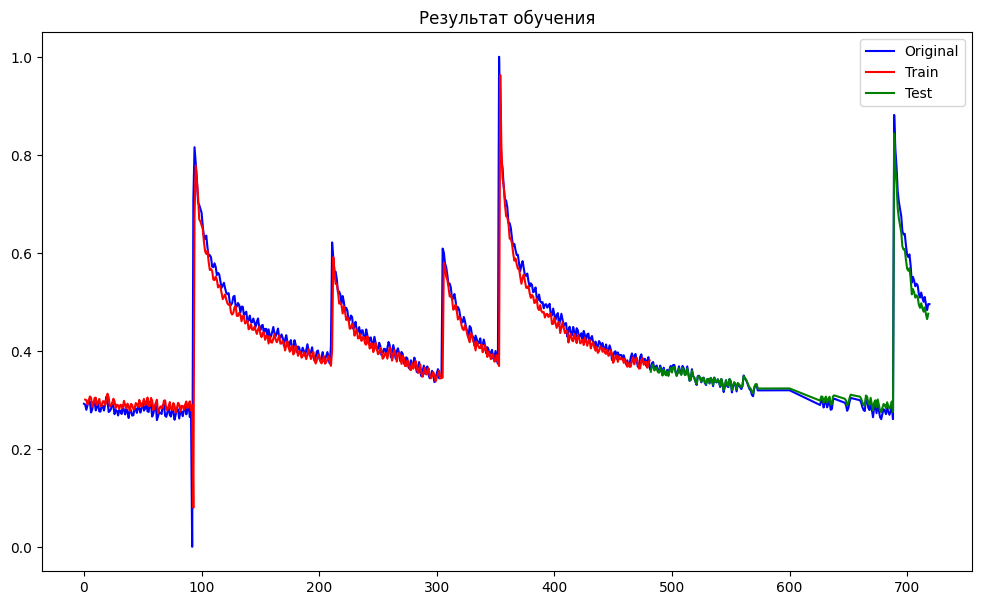

In [21]:
plot_train_n_pred(X_train, X_test, total, model)